In [14]:
import sys
import os
import tensorflow as tf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from model import Deeplabv3

In [4]:
model_new = Deeplabv3(weights=None, 
                      OS=8, 
                      input_shape=(256, 640, 3), 
                      backbone='mobilenetv2', 
                      alpha=1.0, 
                      classes=2,
                      weight_decay=0.0001,
                      dropout=0.1)

model_new.load_weights('../hopefully_right_starting_point.h5')

In [10]:
from my_dataset import MyDataset

train_dataset = MyDataset(filename='../train2.tfrecord',
                              batch_size=4,
                              shape=(256, 640),
                              num_readers=4,
                              num_classes=2,
                              is_training=True,
                              should_shuffle=True,
                              should_repeat=True,
                              should_augment=True).get()

val_dataset = MyDataset(filename='../val2.tfrecord',
                       batch_size=4,
                       shape=(256, 640),
                       num_readers=4,
                       num_classes=2,
                       is_training=True,
                       should_shuffle=True,
                       should_repeat=True,
                       should_augment=False).get()

In [20]:
def make_loss(class_weights):
    num_classes = len(class_weights)
    def loss(labels, pred):
        weight_masks = []
        for i in range(num_classes):
            weight_masks.append(tf.cast(tf.equal(tf.argmax(labels, axis=-1), i), tf.float32) * class_weights[i])

        return tf.compat.v1.losses.softmax_cross_entropy(
            labels,
            pred,
            weights=tf.add_n(weight_masks))
    
    return loss

In [21]:
adam = tf.keras.optimizers.Adam(lr=0.00001)
model_new.compile(optimizer=adam, loss=make_loss([1., 50.]))

In [ ]:
model_new.fit(train_dataset, epochs=100, steps_per_epoch=round(72/4),
             validation_data=val_dataset,
             validation_steps=round(25/4))

In [48]:
model_new.save('depth1_color_aug_val054-059.h5')

In [21]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [130]:
sample = np.array(Image.open('/home/ubuntu/dataset/images/home23_02_2019-02-23-11-55-12_0_frame0671.jpg'))
sample = (sample * 2.0 / 255.0) - 1.0

In [49]:
eval_dir = '/home/ubuntu/2019-02-23-11-55-12_0/'
evals = [os.path.join(eval_dir, f) for f in os.listdir(eval_dir)]

In [50]:
alpha = 0.4
eval_out_dir = '/home/ubuntu/eval_2019-02-23-11-55-12_0/'
if not os.path.exists(eval_out_dir):
    os.makedirs(eval_out_dir)

for e in list(os.listdir(eval_dir)):
    i = np.array(Image.open(os.path.join(eval_dir, e)))
    i = i[-256:, :, :]
    pred = model_new.predict(np.expand_dims(i * 2.0 / 255.0 - 1.0, axis=0))
    
    pred = np.argmax(np.squeeze(pred), axis=2)
    i[pred == 1] = alpha * np.array([0, 255, 0]) + (1 - alpha) * i[pred == 1] 
    
    i = Image.fromarray(i)
    i.save(os.path.join(eval_out_dir, e))

In [164]:
def plot_pred(pred):
    pred = np.squeeze(pred)
    pred = np.argmax(pred, axis=2)
    

    plt.imshow(pred)

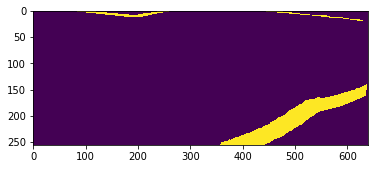

In [140]:
true = np.array(Image.open('/home/ubuntu/dataset/masks/home23_02_2019-02-23-11-55-12_0_frame0671.png'))
plt.imshow(true)